### 01f_community_detection_and_pathfinding — Discovering Subgroups and Routes

### What this step does
This notebook loads the augmented graph from `01e` and explores two key network concepts: **community detection** and **pathfinding**. It first identifies clusters of closely-related nodes (communities) using the Louvain method. It then demonstrates how to find the shortest path between any two nodes, using travel time as the weight.

### Why this is useful
- **Community Detection:** Reveals the natural subgroupings or clusters within a network, which could correspond to geographical regions or functional zones.
- **Pathfinding:** Solves the fundamental problem of finding the most efficient route between two points, which is critical for logistics, planning, and accessibility analysis.
- Provides practical examples of how to apply and visualise these common graph algorithms.

### Inputs
- `outputs/01e_centrality_analysis/graph_with_centrality.graphml`

### Outputs
- `outputs/01f_communities_paths/graph_with_communities.graphml`
- `outputs/01f_communities_paths/01f_community_visualisation.png`
- `outputs/01f_communities_paths/01f_shortest_path_visualisation.png`
- `outputs/01f_communities_paths/01f_path_analysis.json`

### Key operations
- Load the graph containing centrality attributes.
- Apply the Louvain community detection algorithm (`nx.community.louvain_communities`).
- Add a `community_id` attribute to each node.
- Visualise the graph with nodes colored by their assigned community.
- Implement a function to find and calculate the length of the shortest path between two nodes using Dijkstra's algorithm (`nx.shortest_path`).
- Visualise a specific shortest path on the network map.
- Export the final graph and a summary of the path analysis.

In [10]:
# --- Step 0: Imports and Configuration ---
# 203 # Standard setup for imports and configuration management.
# 203 # The Config dataclass ensures all file paths for inputs and outputs
# 203 # are clearly defined and easy to locate, maintaining the modular
# 203 # structure of the notebook series.

from __future__ import annotations

import json
import random
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

# 203 # Display preferences.
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

@dataclass(frozen=True)
class Config:
    """Configuration object for file paths and parameters."""
    input_dir: Path
    output_dir: Path
    input_graph_file: Path
    output_graph_file: Path
    community_viz_file: Path
    path_viz_file: Path
    path_summary_file: Path
    # 203 # Nodes for the pathfinding example.
    path_start_node: str = "N000"
    path_end_node: str = "N024"


def setup_config() -> Config:
    """Initialises configuration and creates directories."""
    root_dir = Path(".")
    input_dir = root_dir / "outputs" / "01e_centrality_analysis"
    output_dir = root_dir / "outputs" / "01f_communities_paths"
    
    output_dir.mkdir(parents=True, exist_ok=True)

    return Config(
        input_dir=input_dir,
        output_dir=output_dir,
        input_graph_file=input_dir / "graph_with_centrality.graphml",
        output_graph_file=output_dir / "graph_with_communities.graphml",
        community_viz_file=output_dir / "01f_community_visualisation.png",
        path_viz_file=output_dir / "01f_shortest_path_visualisation.png",
        path_summary_file=output_dir / "01f_path_analysis.json",
    )

cfg = setup_config()

print("--- Configuration Initialised ---")
print(f"Input graph: {cfg.input_graph_file}")
print(f"Outputs will be saved to: {cfg.output_dir}")

--- Configuration Initialised ---
Input graph: outputs/01e_centrality_analysis/graph_with_centrality.graphml
Outputs will be saved to: outputs/01f_communities_paths


In [11]:
# --- Step 1: Load Graph ---
# 203 # As in the previous notebook, we start by loading the graph from the
# 203 # GraphML file produced by the preceding step. This ensures we have all
# 203 # the node attributes, including centrality scores, available for this analysis.

def load_graph(file_path: Path) -> nx.Graph:
    """Loads a graph from a GraphML file."""
    if not file_path.exists():
        raise FileNotFoundError(
            f"Graph file not found at {file_path}.\n"
            f"Please run notebook '01e_centrality_analysis.ipynb' first."
        )
    G = nx.read_graphml(file_path)
    # 203 # GraphML can read numeric attributes as strings, so we ensure pos is numeric.
    for node, data in G.nodes(data=True):
        if 'pos' in data and isinstance(data['pos'], str):
            # 203 # Safely evaluate the string '(x, y)' back into a tuple.
            try:
                data['pos'] = eval(data['pos'])
            except (SyntaxError, NameError):
                print(f"Warning: Could not parse pos attribute for node {node}")
                data['pos'] = (0, 0)
    print(f"Graph loaded from {file_path}.")
    return G

# 203 # Load the graph.
G = load_graph(cfg.input_graph_file)

Graph loaded from outputs/01e_centrality_analysis/graph_with_centrality.graphml.


In [3]:
# --- Step 2: Community Detection ---
# 203 # This cell performs community detection using the Louvain method, a popular
# 203 # and efficient algorithm for finding modularity-based communities in networks.
# 203 # The detected community ID is then stored as a node attribute.

def detect_and_set_communities(G: nx.Graph):
    """Detects communities using the Louvain method and adds them as node attributes."""
    # 203 # The algorithm is for undirected graphs, so we work on an undirected view.
    # 203 # Travel time ('weight') is used to inform community structure.
    communities = nx.community.louvain_communities(G, weight='weight', seed=42)
    
    # 203 # Create a mapping from node to community ID.
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_to_community[node] = i
            
    nx.set_node_attributes(G, node_to_community, 'community_id')
    num_communities = len(communities)
    print(f"Detected and attached {num_communities} communities.")
    
# 203 # Run the community detection.
detect_and_set_communities(G)

Detected and attached 7 communities.


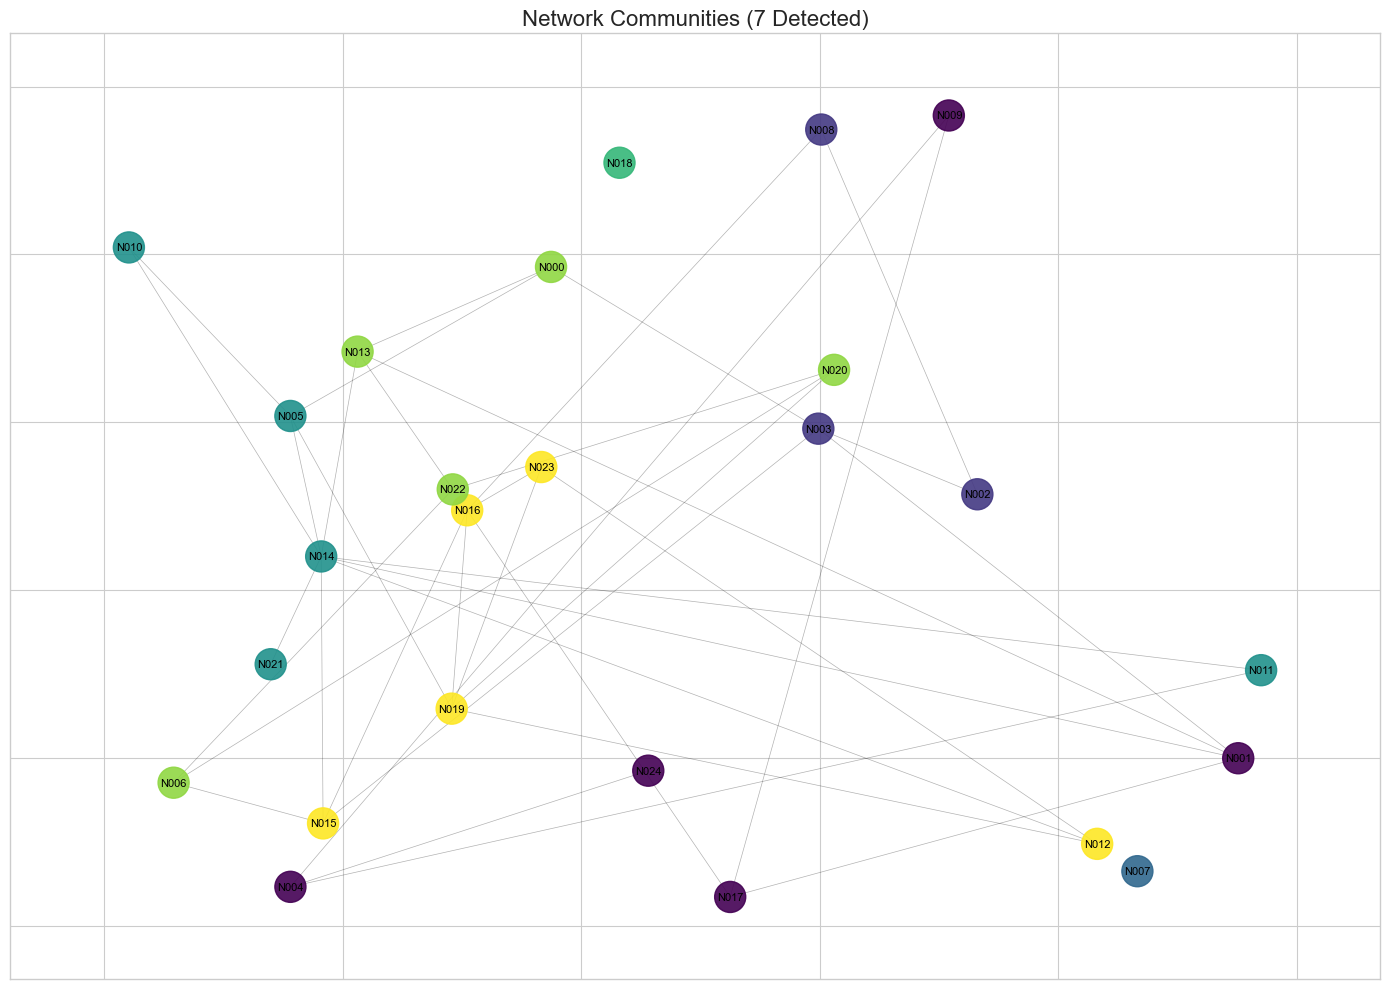

Community visualisation saved to outputs/01f_communities_paths/01f_community_visualisation.png


In [6]:
# --- Step 3: Visualize Communities ---
# 203 # This cell creates a visualisation of the graph where each node is colored
# 203 # according to its community ID. This provides a clear visual map of the
# 203 # network's cluster structure.

def visualize_communities(G: nx.Graph, file_path: Path):
    """Creates a graph plot with nodes colored by community ID."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 10))

    pos = nx.get_node_attributes(G, 'pos')
    community_ids = nx.get_node_attributes(G, 'community_id')
    num_communities = len(set(community_ids.values()))

    # 203 # Generate a color palette for the communities.
    # 203 # Using a perceptually uniform colormap like 'viridis' is good practice.
    colors = plt.cm.viridis(np.linspace(0, 1, num_communities))
    node_colors = [colors[community_ids.get(node, -1)] for node in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', ax=ax)

    ax.set_title(f"Network Communities ({num_communities} Detected)", fontsize=16)
    plt.tight_layout()
    fig.savefig(file_path, dpi=200)
    plt.show()
    print(f"Community visualisation saved to {file_path}")

# 203 # Run the visualisation.
visualize_communities(G, cfg.community_viz_file)

Shortest path from N000 to N024: ['N000', 'N005', 'N014', 'N011', 'N004', 'N024']
Total travel time: 175.00 minutes


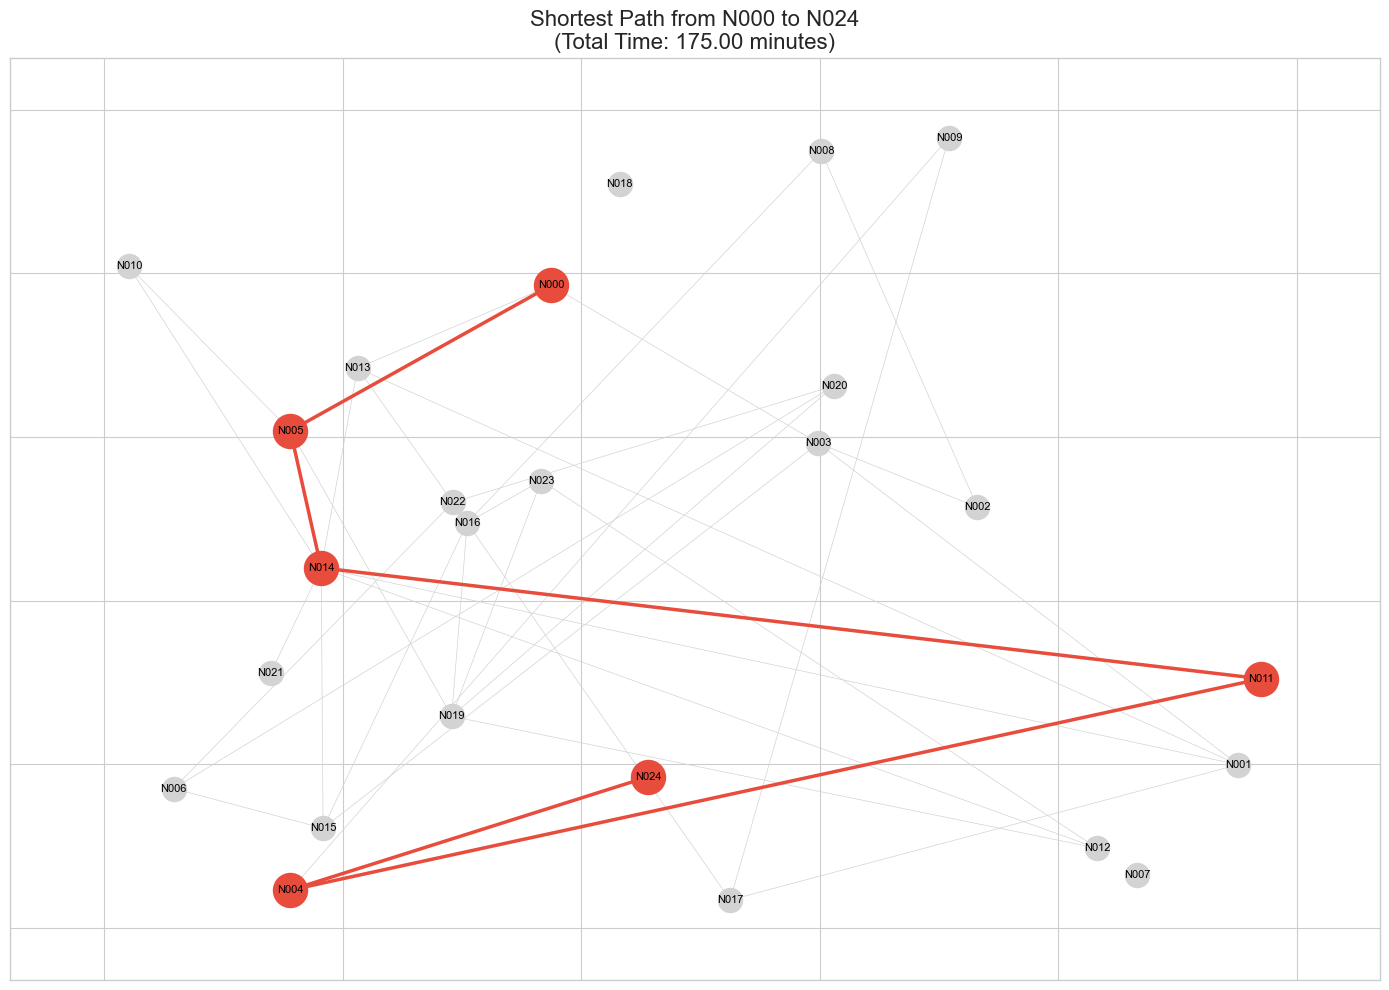

Shortest path visualisation saved to outputs/01f_communities_paths/01f_shortest_path_visualisation.png


In [7]:
# --- Step 4: Pathfinding ---
# 203 # This cell focuses on finding the shortest path between two nodes.
# 203 # A single-role function is created to handle the path calculation and
# 203 # another function to visualise the result, separating logic from presentation.

def find_shortest_path(G: nx.Graph, start_node: str, end_node: str) -> dict:
    """Finds the shortest path and its length between two nodes."""
    if start_node not in G or end_node not in G:
        print(f"Warning: Start ({start_node}) or end ({end_node}) node not in graph.")
        return None

    try:
        # 203 # Use Dijkstra's algorithm, weighted by travel time.
        path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
        length = nx.shortest_path_length(G, source=start_node, target=end_node, weight='weight')
        print(f"Shortest path from {start_node} to {end_node}: {path}")
        print(f"Total travel time: {length:.2f} minutes")
        return {"start_node": start_node, "end_node": end_node, "path": path, "total_time": length}
    except nx.NetworkXNoPath:
        print(f"No path exists between {start_node} and {end_node}.")
        return None


def visualize_shortest_path(G: nx.Graph, path_info: dict, file_path: Path):
    """Visualises the graph, highlighting the specified shortest path."""
    if not path_info or 'path' not in path_info:
        print("No path information to visualize.")
        return

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 10))
    pos = nx.get_node_attributes(G, 'pos')
    path_nodes = path_info['path']
    path_edges = list(zip(path_nodes[:-1], path_nodes[1:]))

    # 203 # Draw the full graph dimly in the background.
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=300, ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=0.5, ax=ax)

    # 203 # Highlight the nodes and edges in the shortest path.
    nx.draw_networkx_nodes(G, pos, nodelist=path_nodes, node_color='#e74c3c', node_size=600, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='#e74c3c', width=2.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='black', ax=ax)

    title = f"Shortest Path from {path_info['start_node']} to {path_info['end_node']}\n"
    title += f"(Total Time: {path_info['total_time']:.2f} minutes)"
    ax.set_title(title, fontsize=16)
    plt.tight_layout()
    fig.savefig(file_path, dpi=200)
    plt.show()
    print(f"Shortest path visualisation saved to {file_path}")

# 203 # Find and visualize the shortest path between the configured nodes.
path_analysis = find_shortest_path(G, cfg.path_start_node, cfg.path_end_node)
if path_analysis:
    visualize_shortest_path(G, path_analysis, cfg.path_viz_file)

In [12]:
# --- Step 5: Export Artifacts ---
# 203 # This cell saves the graph (now with community attributes) and the results
# 203 # of the pathfinding analysis. This ensures all work is persisted for potential
# 203 # use in the final notebook or other applications.

def export_artifacts(G: nx.Graph, path_analysis: dict, graph_path: Path, summary_path: Path):
    """Saves the graph to GraphML and path analysis to JSON."""
    # 203 # Create a copy to avoid modifying the graph in memory during export.
    G_export = G.copy()

    # 203 # SOLVED: Convert the 'pos' tuple attribute back to a string before saving to GraphML,
    # 203 # as the format does not support tuple data types.
    for node, data in G_export.nodes(data=True):
        if 'pos' in data and isinstance(data['pos'], tuple):
            data['pos'] = str(data['pos'])

    # 203 # Save the graph with community attributes.
    nx.write_graphml(G_export, graph_path)
    print(f"Graph with community data saved to {graph_path}")
    
    # 203 # Save the path analysis summary.
    if path_analysis:
        with open(summary_path, 'w') as f:
            json.dump(path_analysis, f, indent=2)
        print(f"Path analysis summary saved to {summary_path}")

# 203 # Run the export function.
export_artifacts(G, path_analysis, cfg.output_graph_file, cfg.path_summary_file)


Graph with community data saved to outputs/01f_communities_paths/graph_with_communities.graphml
Path analysis summary saved to outputs/01f_communities_paths/01f_path_analysis.json
